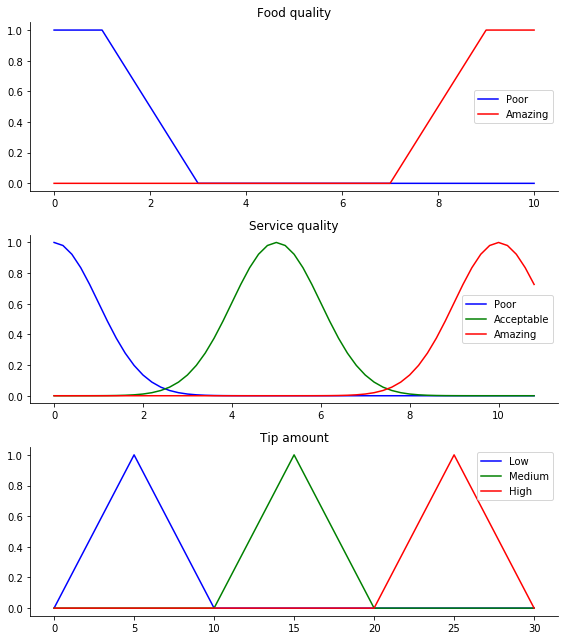

In [7]:
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt

x_qual = np.arange(0, 11, 1) #품질 범위
x_serv = np.arange(0,11, 0.2) #서비스 만족도 범위
x_tip = np.arange(0, 31, 1) #팁 범위

#소속함수 정의
#퀄리티 소속함수 : 사다리꼴
qual_poor = fuzz.trapmf(x_qual, [0,0,1,3]) #poor 소속함수 
qual_amazing = fuzz.trapmf(x_qual, [7,9,10,10]) #amazing 소속함수

#서비스 만족도 소속함수 : 가우시안
serv_poor = fuzz.gaussmf(x_serv, 0, 1) #평균, 편차
serv_acceptable = fuzz.gaussmf(x_serv, 5, 1)
serv_amazing = fuzz.gaussmf(x_serv, 10, 1)

#팁 소속함수 : 삼각 함수
tip_low = fuzz.trimf(x_tip, [0, 5, 10])
tip_medium = fuzz.trimf(x_tip, [10, 15, 20])
tip_high = fuzz.trimf(x_tip, [20, 25, 30])

#소속함수 그리기
fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (8,9))

ax0.plot(x_qual, qual_poor, 'b', linewidth = 1.5, label = 'Poor')
ax0.plot(x_qual, qual_amazing, 'r', linewidth = 1.5, label = 'Amazing')
ax0.set_title('Food quality')
ax0.legend()

ax1.plot(x_serv, serv_poor, 'b', linewidth = 1.5, label = 'Poor')
ax1.plot(x_serv, serv_acceptable, 'g', linewidth = 1.5, label = 'Acceptable')
ax1.plot(x_serv, serv_amazing, 'r', linewidth = 1.5, label = 'Amazing')
ax1.set_title('Service quality')
ax1.legend()

ax2.plot(x_tip, tip_low, 'b', linewidth = 1.5, label = 'Low')
ax2.plot(x_tip, tip_medium, 'g', linewidth = 1.5, label = 'Medium')
ax2.plot(x_tip, tip_high, 'r', linewidth = 1.5, label = 'High')
ax2.set_title('Tip amount')
ax2.legend()

for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
plt.tight_layout()

In [12]:
#소속함수 : mf, 주어지는 값 : val, 범위 : domain
def membership(domain, mf, val):
    return fuzz.interp_membership(domain, mf, val)

#퍼지 규칙 적용하여 tip 계산
def compute_tip_amount(qual_val, serv_val):
    qual_level_poor = membership(x_qual, qual_poor, qual_val) #소속함수로 변형된값
    qual_level_amazing = membership(x_qual, qual_amazing, qual_val)
    
    serv_level_poor = membership(x_serv, serv_poor, serv_val)
    serv_level_acceptable = membership(x_serv, serv_acceptable, serv_val)
    serv_level_amazing = membership(x_serv, serv_amazing, serv_val)
    
    #service= poor or food = poor -> tip = low
    #fmax -> 같은 위치에 있는 원소 비교 (element-wise), 더 큰값를 해당 자리에
    satisfaction_rule1 = np.fmax(qual_level_poor, serv_level_poor)
    tip_activation_low = np.fmin(satisfaction_rule1, tip_low)#rule1보다 작은 tiplow를 남긴다.
    
    #service = acceptable, tip = medium
    tip_activation_medium = np.fmin(serv_level_acceptable, tip_medium)
    
    #service= amazing or food = amazing -> tip = high
    satisfaction_rule3 = np.fmax(qual_level_amazing, serv_level_amazing)
    tip_activation_high = np.fmin(satisfaction_rule3, tip_high)
    
    tip0 = np.zeros_like(x_tip)
    
    #추론결과 결합
    aggregated = np.fmax(tip_activation_low, 
                        np.fmax(tip_activation_medium, tip_activation_high))
    
    #비퍼지화
    tip = fuzz.defuzz(x_tip, aggregated, 'centroid')
    return tip

print('food quality score : 6.6, service scroe : 9 --> ', compute_tip_amount(6.6, 9))

food quality score : 6.6, service scroe : 9 -->  24.992850007852898


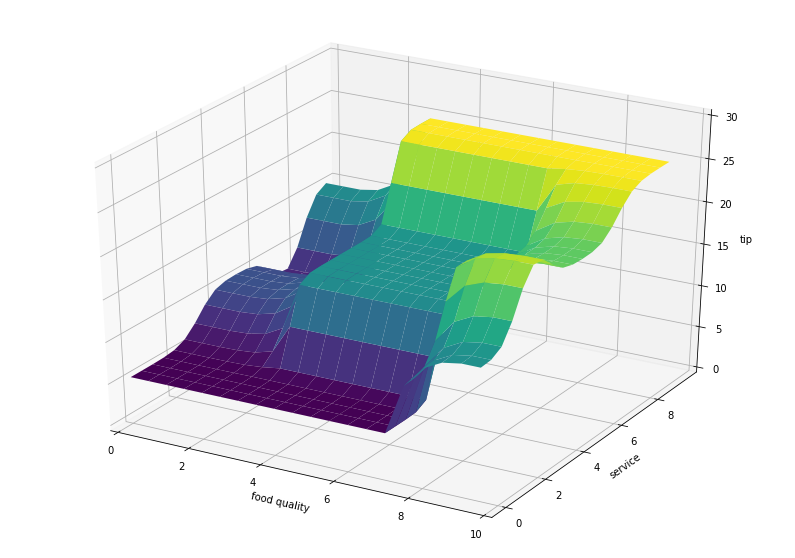

In [16]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

d_qual = np.arange(0, 10, 0.5) #음식 풀질 범위
d_serv = np.arange(0, 10, 0.5) #서비스 만족도 범위

Q, S = np.meshgrid(d_qual, d_serv)
T = np.zeros_like(Q)

for i in range(20):
    for j in range(20):
        T[i,j] = compute_tip_amount(Q[i,j], S[i,j])

fig = plt.figure(figsize = (14, 10))
ax = plt.axes(projection = '3d')
ax.plot_surface(Q, S, T, rstride = 1, cstride = 1, cmap = 'viridis',
               linewidth = 0.4, antialiased = True)

ax.set_xlabel('food quality')
ax.set_xlim(0, 10)
ax.set_ylabel('service')
ax.set_xlim(0, 10)
ax.set_zlabel('tip')
ax.set_zlim(0, 30)

plt.show()